# SERIES TEMPORALES: MODELOS PREDICTIVOS
## Facebook's Prophet

`v2.2`
---


En 2017 Facebook diseñó Prophet, un algoritmo de código abierto de pronóstico que ayuda tanto a los expertos como a los no expertos a realizar predicciones de calidad, ya que cuenta con predicciones personalizables intuitivas para todos los usuarios .

Prophet es un procedimiento para pronosticar datos de series temporales basado en un modelo aditivo en el que las tendencias no lineales se ajustan a la estacionalidad anual, semanal y diaria, además de los efectos de las vacaciones. 

Funciona mejor con series temporales que tienen fuertes efectos estacionales y varias temporadas de datos históricos. Adicionalmente, cabe destacar que es resistente a los datos faltantes y los cambios en la tendencia y, por lo general, maneja bien los valores atípicos. 
 
Prophet se construyó usando Stan, un lenguaje de programación de probabilidades que se conecta con varias plataformas populares de analítica como MATLAB y Stata además de Python y R. 

El modelo Prophet se puede representar como:

y(t)=g(t)+s(t)+h(t)+x(t)+ᶓ(t)

Donde:  
•	g(t) = es el término de crecimiento  
•	s(t) = describe los diversos patrones estacionales  
•	h(t) = captura los efectos de las vacaciones que se agregan como variables ficticias simples  
•   x(t) = regresores  
•	ᶓ(t) = es el término de error de ruido blanco  
  


In [1]:
# 
import os, sys
from google.colab import drive
drive.mount('/content/mnt', force_remount=True)
nb_path = '/content/notebooks'
os.symlink('/content/mnt/My Drive/Colab Notebooks/Librerias', nb_path)
#sys.path.insert(0, nb_path)  # or append(nb_path)
sys.path.append(nb_path)  # or append(nb_path)

Mounted at /content/mnt


In [4]:
import warnings
warnings.filterwarnings('ignore')

# Visitas Restaurantes

El negocio de los restaurantes puede ser impredecible, con muchos factores que pueden arruinar fácilmente un negocio. Predecir la cantidad de visitantes que tendrá un restaurante dado un conjunto específico de características.

## Preparar la variable dependiente

In [5]:
import pandas as pd
y = pd.read_csv("/Users/juan/Documents/Juan's MacBook Pro/CUNEF/Quinto/Analisis Predictivo/Clase/air_visit_data.csv.zip")
y = y.pivot(index='visit_date', columns='air_store_id')['visitors']
y = y.fillna(0)
y = pd.DataFrame(y.sum(axis=1))
y.tail()


,0
visit_date,
2017-04-18,13489.0
2017-04-19,14607.0
2017-04-20,13990.0
2017-04-21,19624.0
2017-04-22,21245.0


## Preparar el DATA frame para Prophet

In [6]:
y = y.reset_index(drop=False)
y.columns = ['ds', 'y']
y.tail()


,ds,y
473,2017-04-18,13489.0
474,2017-04-19,14607.0
475,2017-04-20,13990.0
476,2017-04-21,19624.0
477,2017-04-22,21245.0


<AxesSubplot: >

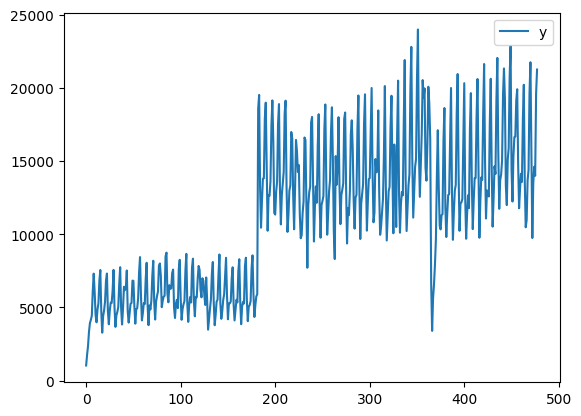

In [7]:
import matplotlib.pyplot as plt
y.plot()

## Dividir la muestra en train-test

In [8]:
train = y.iloc[:450,:]
test = y.iloc[450:,:]


In [9]:
 #pip install --upgrade plotly

## Crear un modelo Prophet Básico
https://facebook.github.io/prophet/
# Install pystan with pip before using pip to install prophet
# pystan>=3.0 is currently not supported

## Estimar el modelo

In [10]:
from prophet import Prophet
m = Prophet()
m.fit(train)


16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing


## Predicción  del modelo Prophet

In [11]:
future = m.make_future_dataframe(periods=len(test))
forecast = m.predict(future)


## Evaluación de la predicción

$$R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$$

In [12]:
from sklearn.metrics import r2_score
print(r2_score(list(test['y']), list(forecast.loc[450:,'yhat'] )))


0.8101174542671182


## Graficar el modelo

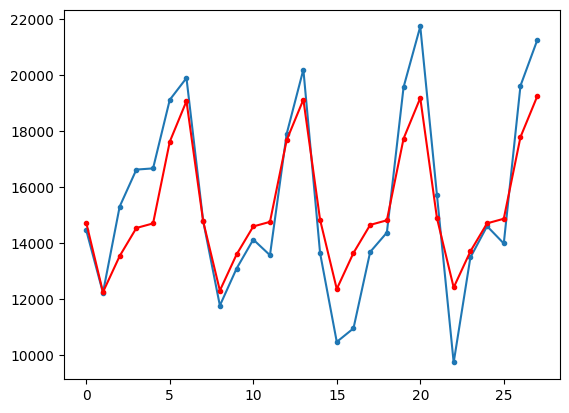

In [13]:
import matplotlib.pyplot as plt
plt.plot(list(test['y']),'.-')
plt.plot(list(forecast.loc[450:,'yhat']),'r.-')
plt.show()


## Gráfico de la predición

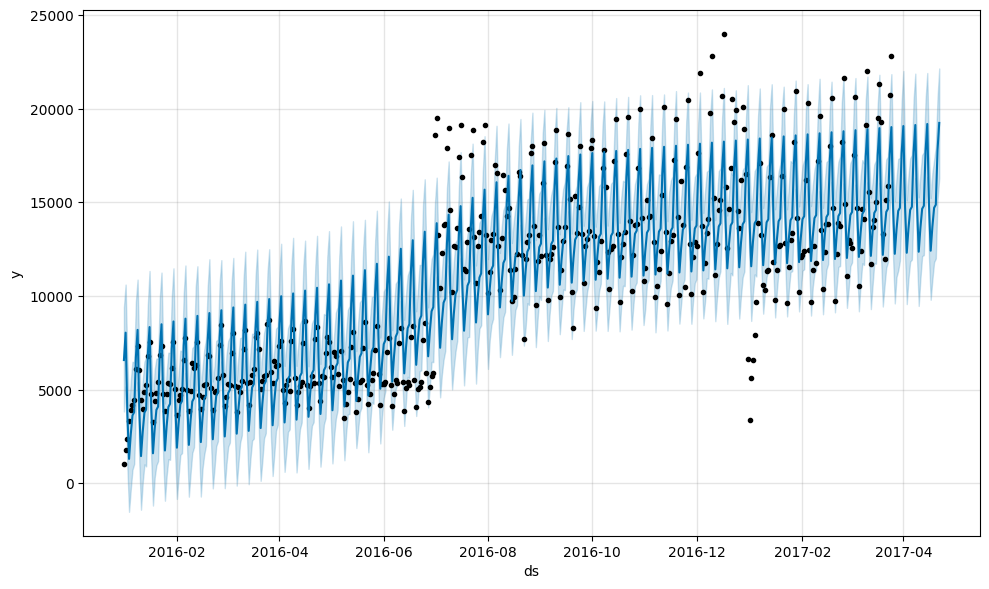

In [14]:
fig1 = m.plot(forecast)
plt.show()


## Descomposición

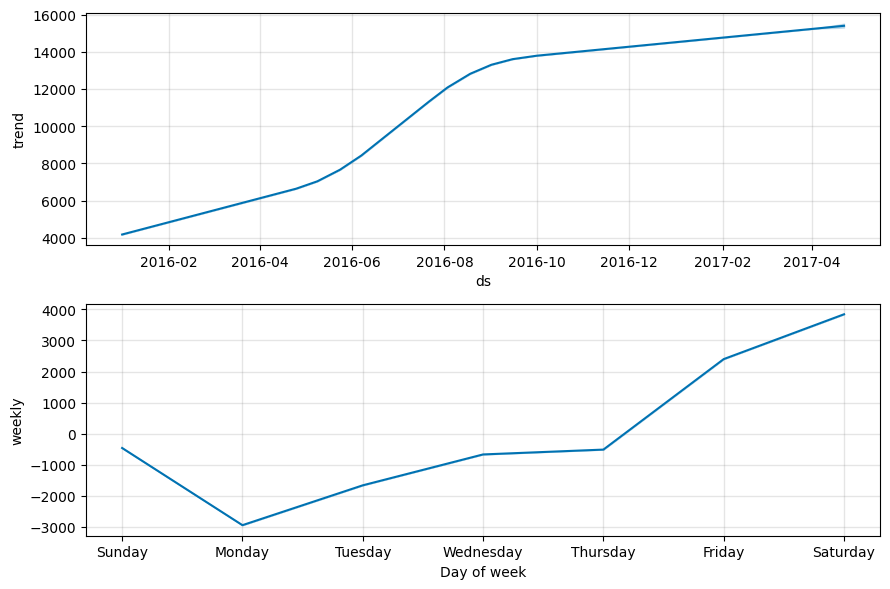

In [15]:
fig2 = m.plot_components(forecast)
plt.show()


## Añadimos estacionalidad mensual

In [16]:
m2 = Prophet()
m2.add_seasonality(name='monthly', period=30.5, fourier_order=5)

m2.fit(train)

future2 = m2.make_future_dataframe(periods=len(test))
forecast2 = m2.predict(future)
print(r2_score(list(test['y']), list(forecast2.loc[450:,'yhat'] )))


16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing


0.7910860073715045


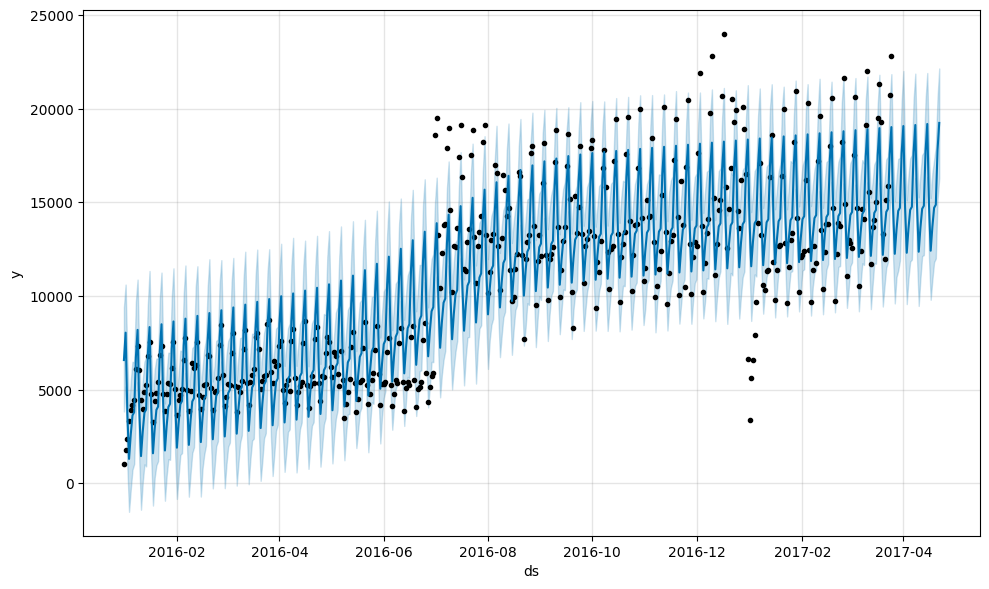

In [17]:
fig1 = m2.plot(forecast)
plt.show()

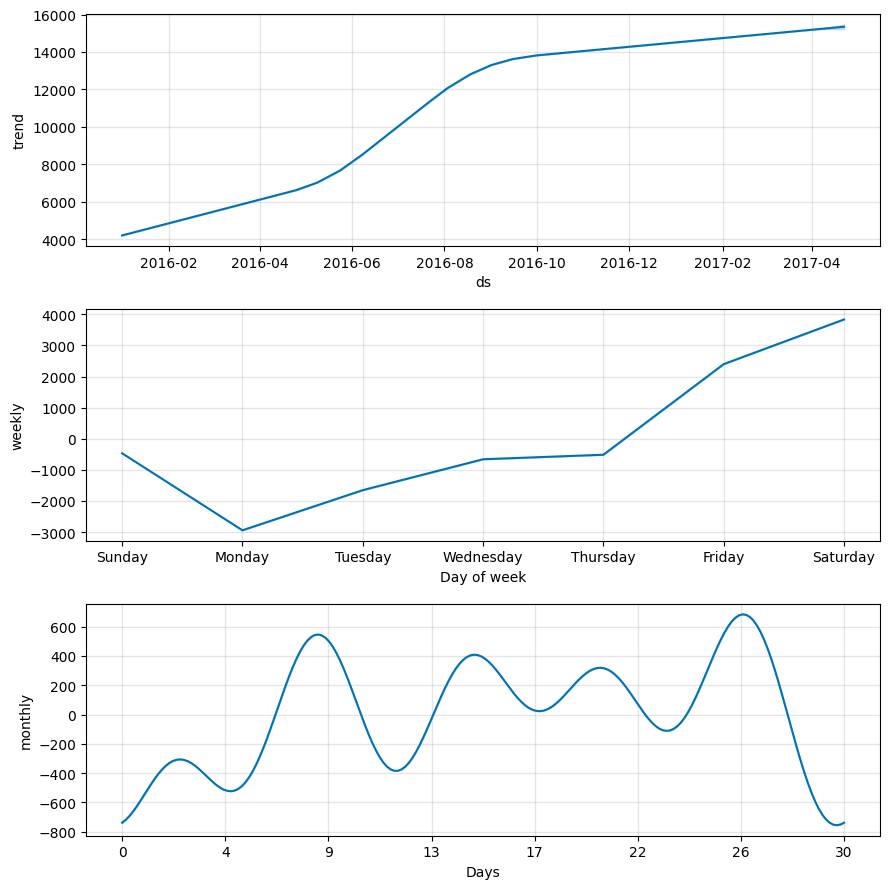

In [18]:

fig2 = m2.plot_components(forecast2)
plt.show()


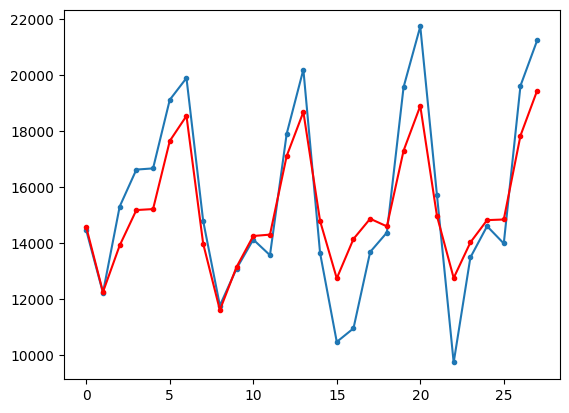

In [19]:
plt.plot(list(test['y']),'.-')
plt.plot(list(forecast2.loc[450:,'yhat']),'r.-')
plt.show()

In [20]:
# R2
print(r2_score(list(test['y']), list(forecast2.loc[450:,'yhat'] )))

0.7910860073715045


##  Fiestas

In [24]:
holidays = pd.read_csv("/Users/juan/Documents/Juan's MacBook Pro/CUNEF/Quinto/Analisis Predictivo/Clase/date_info.csv.zip")
holidays.tail()


,calendar_date,day_of_week,holiday_flg
512,2017-05-27,Saturday,0
513,2017-05-28,Sunday,0
514,2017-05-29,Monday,0
515,2017-05-30,Tuesday,0
516,2017-05-31,Wednesday,0


In [25]:

holidays = holidays[holidays['holiday_flg'] == 1]
holidays = holidays[['calendar_date', 'holiday_flg']]
holidays = holidays.drop(['holiday_flg'], axis=1)
holidays['holiday'] = 'holiday'
holidays.columns = ['ds', 'holiday']
holidays.tail()

,ds,holiday
444,2017-03-20,holiday
484,2017-04-29,holiday
488,2017-05-03,holiday
489,2017-05-04,holiday
490,2017-05-05,holiday


## Añadimos las fiestas al modelo

In [26]:
m3 = Prophet(holidays=holidays)
m3.fit(train)
future3 = m3.make_future_dataframe(periods=len(test))
forecast3 = m3.predict(future)

print(r2_score(list(test['y']), list(forecast3.loc[450:,'yhat'] )))


16:26:06 - cmdstanpy - INFO - Chain [1] start processing
16:26:06 - cmdstanpy - INFO - Chain [1] done processing


0.8085968068750733


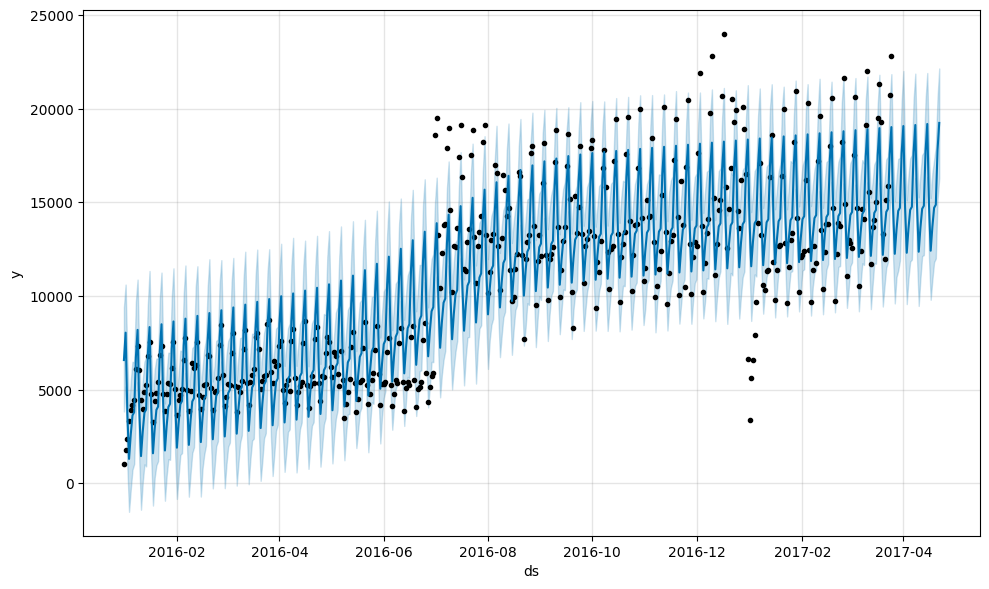

In [27]:
fig1 = m3.plot(forecast)
plt.show()

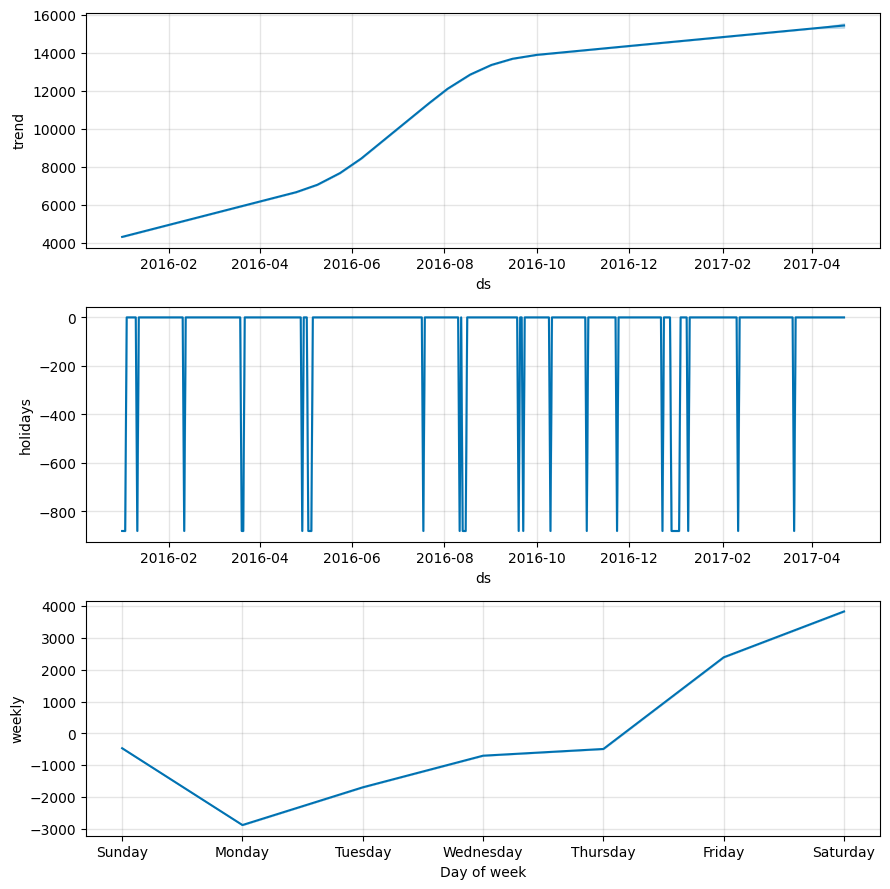

In [28]:

fig2 = m3.plot_components(forecast3)
plt.show()


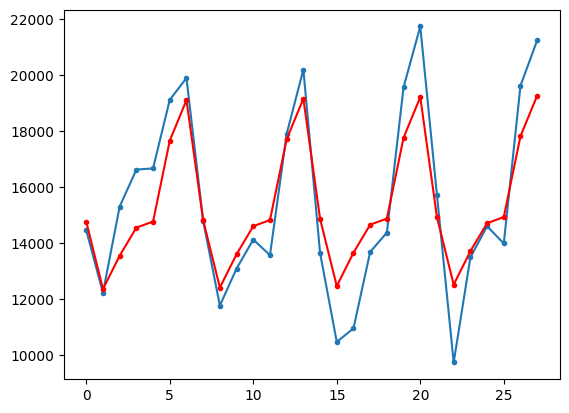

In [29]:
plt.plot(list(test['y']),'.-')
plt.plot(list(forecast3.loc[450:,'yhat']),'r.-')
plt.show()

In [30]:
# R2
print(r2_score(list(test['y']), list(forecast3.loc[450:,'yhat'] )))

0.8085968068750733


## Reservas

In [24]:
X_reservations = pd.read_csv('/content/mnt/My Drive/Colab Notebooks/Series Temporales/S11/air_reserve.csv.zip')
X_reservations['visit_date'] = pd.to_datetime(X_reservations['visit_datetime']).dt.date
X_reservations = pd.DataFrame(X_reservations.groupby('visit_date')['reserve_visitors'].sum())
X_reservations = X_reservations.reset_index(drop = False)
train4 = train.copy()
train4['ds'] = pd.to_datetime(train4['ds']).dt.date
train4 = train4.merge(X_reservations, left_on = 'ds', right_on = 'visit_date', how = 'left')[['ds', 'y', 'reserve_visitors']].fillna(0)
train4.tail()

,ds,y,reserve_visitors
445,2017-03-21,11987.0,1357.0
446,2017-03-22,15101.0,2071.0
447,2017-03-23,15879.0,1789.0
448,2017-03-24,20720.0,3866.0
449,2017-03-25,22836.0,3233.0


## Añadimos las reservas al modelo

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp9jyuhop/1d1kn02y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp9jyuhop/5h37tpmu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43137', 'data', 'file=/tmp/tmpp9jyuhop/1d1kn02y.json', 'init=/tmp/tmpp9jyuhop/5h37tpmu.json', 'output', 'file=/tmp/tmpp9jyuhop/prophet_modelh51gabb8/prophet_model-20221128104440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:44:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:44:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


0.8399746522203142


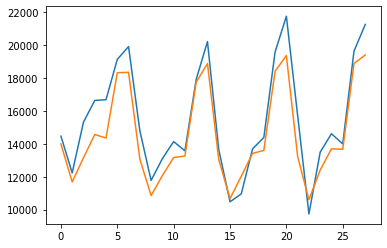

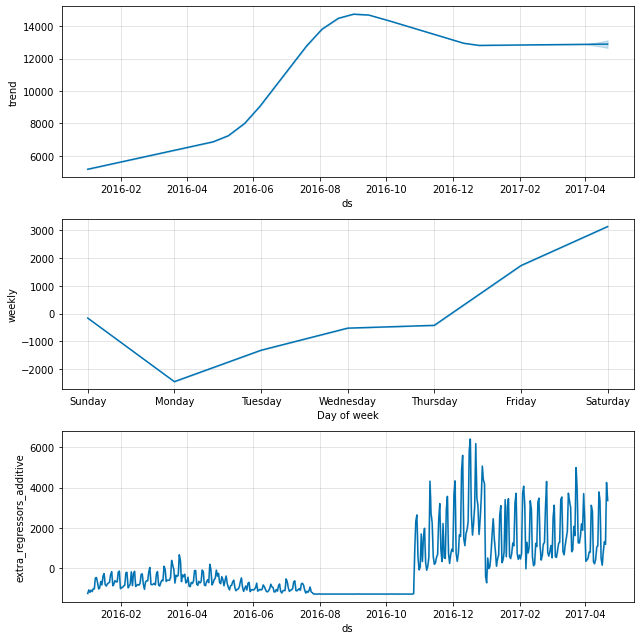

In [25]:
m4 = Prophet()
m4.add_regressor('reserve_visitors')
m4.fit(train4)
future4 = m4.make_future_dataframe(periods=len(test))
future4['ds'] = pd.to_datetime(future4['ds']).dt.date

future4 = future4.merge(X_reservations, left_on = 'ds', right_on = 'visit_date', how = 'left')[['ds', 'reserve_visitors']].fillna(0)

forecast4 = m4.predict(future4)

print(r2_score(list(test['y']), list(forecast4.loc[450:,'yhat'] )))

plt.plot(list(test['y']))
plt.plot(list(forecast4.loc[450:,'yhat'] ))

fig2 = m4.plot_components(forecast4)
plt.show()


## Grid de búsqueda Prophet

In [27]:
def model_test(holidays, weekly_seasonality,
yearly_seasonality, add_monthly, add_reserve, changepoint_prior_scale, holidays_prior_scale, month_fourier):
    
    m4 = Prophet(
        yearly_seasonality=yearly_seasonality, 
        weekly_seasonality=weekly_seasonality, 
        holidays=holidays, 
        changepoint_prior_scale=changepoint_prior_scale, 
        holidays_prior_scale=holidays_prior_scale)
    
    if add_monthly:    
        m4.add_seasonality(
            name='monthly', 
            period=30.5, 
            fourier_order=month_fourier)
                
    if add_reserve:
        m4.add_regressor('reserve_visitors')

    m4.fit(train4)

    future4 = m4.make_future_dataframe(periods=len(test))

    future4['ds'] = pd.to_datetime(future4['ds']).dt.date
    
    if add_reserve:
        future4 = future4.merge(
            X_reservations, 
            left_on = 'ds', 
            right_on = 'visit_date', 
            how = 'left')
        future4 = future4[['ds', 'reserve_visitors']]
        future4 = future4.fillna(0)

    forecast4 = m4.predict(future4)

    return r2_score(
            list(test['y']),
            list(forecast4.loc[450:,'yhat'] )) 



In [ ]:

# Setting the grid
holidays_opt = [holidays, None]
weekly_seas = [ 5, 10, 30, 50]
yearly_seas = [ 5, 10, 30, 50]
add_monthly = [True, False]
add_reserve = [True, False]
changepoint_prior_scale = [0.1, 0.3, 0.5]
holidays_prior_scale = [0.1, 0.3, 0.5]
month_fourier = [5, 10, 30, 50]

# Looping through the grid
grid_results = []
for h in holidays_opt:
  for w in weekly_seas:
    for ys in yearly_seas:
      for m in add_monthly:
        for r in add_reserve:
           for c in changepoint_prior_scale:
             for hp in holidays_prior_scale:
               for mf in month_fourier:
                  r2=model_test(h,w,ys,m,r,c,hp,mf)
                  print([w,ys,m,r,c,hp,mf,r2])
                  grid_results.append([h,w,ys,m,r,c,hp,mf,r2])

# adding it all to a dataframe and extract the best model
benchmark = pd.DataFrame(grid_results)
benchmark = benchmark.sort_values(8, ascending=False)

h, w,ys, m, r, c,hp,mf,r2 = list(benchmark.iloc[0,:])

# Fit the Prophet with those best hyperparameters
m4 = Prophet(
        yearly_seasonality=ys, 
        weekly_seasonality=w, 
        holidays=h, 
        changepoint_prior_scale=c, 
        holidays_prior_scale=hp)
    
if m:    
    m4.add_seasonality(
        name='monthly', 
        period=30.5, 
        fourier_order=mf)

if r:
    m4.add_regressor('reserve_visitors')

m4.fit(train4)

future4 = m4.make_future_dataframe(periods=len(test))

future4['ds'] = pd.to_datetime(future4['ds']).dt.date

if r:
    future4 = future4.merge(
            X_reservations, 
            left_on = 'ds', 
            right_on = 'visit_date', 
            how = 'left')
    future4 = future4[['ds', 'reserve_visitors']]
    future4 = future4.fillna(0)

forecast4 = m4.predict(future4)


Este modelo ajustado da un R2 de 0,928. La modelo utiliza la tendencia, semanal
y la estacionalidad anual, junto con el número de reservas como regresor extra.
El orden de estacionalidad semanal es 50 y el orden de Fourier de estacionalidad anual es 10. El
"changepoint_prior_scale" es 0.1, y "holidays_prior_scale" no importa y
las vacaciones no se utilizan en el modelo final.

In [29]:


m5 = Prophet(
        yearly_seasonality=10, 
        weekly_seasonality=50, 
        holidays=None, 
        changepoint_prior_scale=0.1)
    
m5.add_seasonality(
        name='monthly', 
        period=30.5, 
        fourier_order=10)

m5.add_regressor('reserve_visitors')

m5.fit(train4)

future5 = m5.make_future_dataframe(periods=len(test))

future5['ds'] = pd.to_datetime(future5['ds']).dt.date
future5 = future5.merge(
            X_reservations, 
            left_on = 'ds', 
            right_on = 'visit_date', 
            how = 'left')
future5 = future5[['ds', 'reserve_visitors']]
future5 = future5.fillna(0)

forecast5 = m5.predict(future5)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp9jyuhop/v_vm96zl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp9jyuhop/egnq0s91.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84392', 'data', 'file=/tmp/tmpp9jyuhop/v_vm96zl.json', 'init=/tmp/tmpp9jyuhop/egnq0s91.json', 'output', 'file=/tmp/tmpp9jyuhop/prophet_modelgzh9jh3y/prophet_model-20221128104632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:46:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:46:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [30]:
r2_score(list(test['y']),list(forecast5.loc[450:,'yhat'] ))

0.9231365189260624

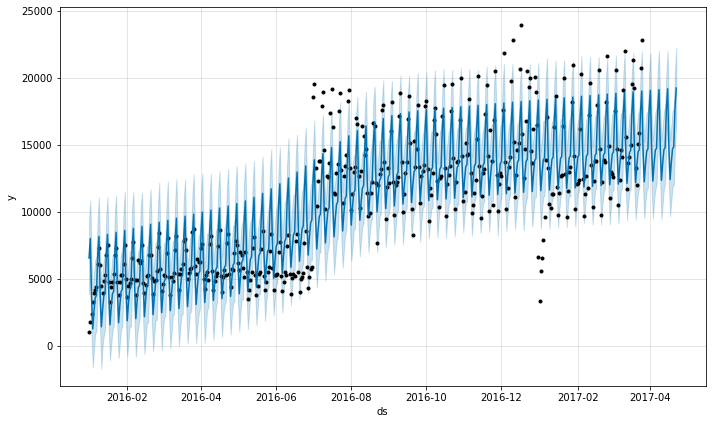

In [32]:
fig1 = m5.plot(forecast)
plt.show()

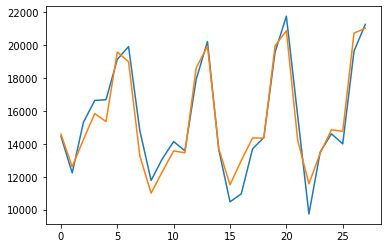

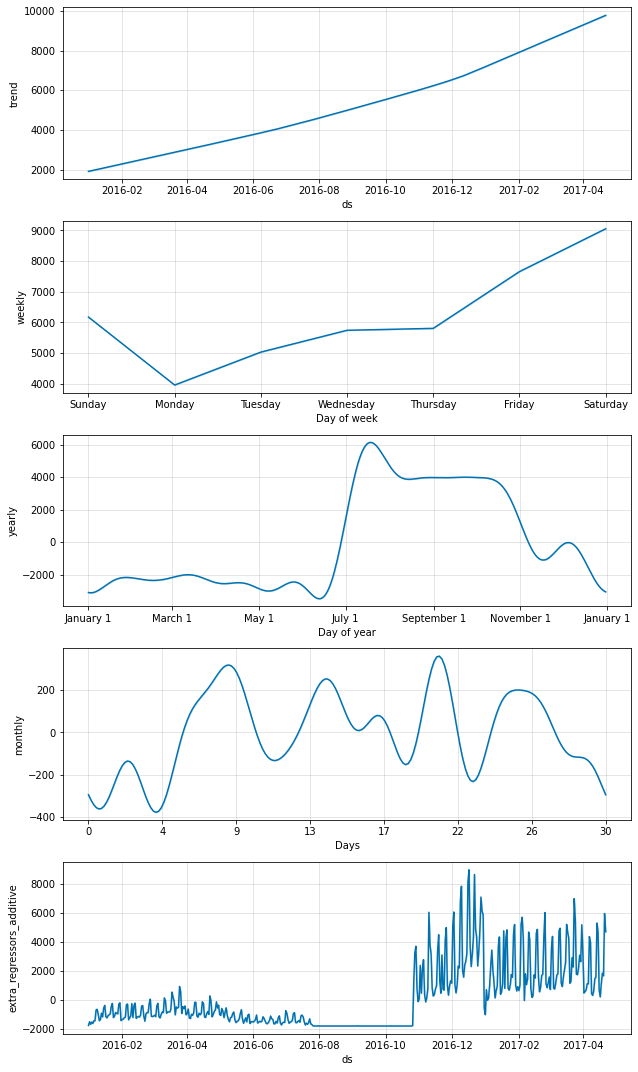

In [31]:
plt.plot(list(test['y']))
plt.plot(list(forecast5.loc[450:,'yhat'] ))

fig2 = m5.plot_components(forecast5)
plt.show()
